In [2]:
#Importing Libraries
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
# Creating a Neural Netwrok Model
class model(nn.Module):
    def __init__(self, hidden_layers):
        super(model, self).__init__()
        layers = []
        layers.append(nn.Linear(1, hidden_layers[0]))
        layers.append(nn.Tanh())
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_layers[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [4]:
# defining a mathematical function called factorial
def factorial(n):
    if n == 0 or n == 1:
        return 1
    return n * factorial(n - 1)

In [5]:
def psi(x, n, mass=1, omega=1, hbar=1):
    def hermite(n, x):
        if n == 0:
            return torch.ones_like(x)
        elif n == 1:
            return 2 * x
        else:
            return 2 * x * hermite(n-1, x) - 2 * (n-1) * hermite(n-2, x)

    mass = torch.tensor(mass, dtype=torch.float32)
    omega = torch.tensor(omega, dtype=torch.float32)
    hbar = torch.tensor(hbar, dtype=torch.float32)

    factor_term = 1 / torch.sqrt(torch.tensor(2.0**n * factorial(n), dtype=torch.float32))
    alpha = torch.sqrt(mass * omega / hbar)
    exp_term = torch.exp(-alpha * x**2 / 2)
    hermite_term = hermite(n, alpha * x)
    return factor_term * (alpha / torch.pi)**0.25 * exp_term * hermite_term

In [6]:
def physics_loss(model, x, n, mass=1.0, omega=1.0, hbar=1.0):
    x.requires_grad_(True)
    u = model(x)

    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

    mass = torch.tensor(mass, dtype=torch.float32)
    omega = torch.tensor(omega, dtype=torch.float32)
    hbar = torch.tensor(hbar, dtype=torch.float32)

    potential = 0.5 * mass * omega**2 * x**2
    energy = hbar * omega * (n + 0.5)
    ph_loss = -0.5 * hbar**2 / mass * d2u_dx2 + potential * u - energy * u

    return torch.mean(ph_loss**2)

In [7]:
def boundary_loss(model, x_min, x_max):
    u_min = model(x_min)
    u_max = model(x_max)
    return torch.mean(u_min**2) + torch.mean(u_max**2)

In [8]:
def plot_progress(nn_model, pinn_model, x_train, u_train, x_eval, u_true, epoch, nn_loss, pinn_loss, img_dir, files):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    nn_pred = nn_model(x_eval).detach()
    pinn_pred = pinn_model(x_eval).detach()

    # Plot for Normal Neural Network
    ax1.plot(x_eval.numpy(), u_true.numpy(), label='Numerical Solution', color='blue', linewidth=1)
    ax1.plot(x_eval.numpy(), nn_pred.numpy(), label='Normal Neural Network', linestyle='--', color='green', linewidth=2)
    ax1.scatter(x_train.numpy(), u_train.numpy(), color='red', label='Training Data', s=30)
    ax1.set_title(f'Normal NN - Epoch {epoch}, Loss: {nn_loss:.4e}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('ψ(x)')
    ax1.set_ylim(-1, 1.5)
    ax1.grid(True)
    ax1.legend()

    # Plot for PINN Model
    ax2.plot(x_eval.numpy(), u_true.numpy(), label='Numerical Solution', color='blue', linewidth=1)
    ax2.plot(x_eval.numpy(), pinn_pred.numpy(), label='PINN Model', linestyle='--', color='black', linewidth=3)
    ax2.scatter(x_train.numpy(), u_train.numpy(), color='red', label='Training Data', s=30)
    ax2.set_title(f'PINN Model - Epoch {epoch}, Loss: {pinn_loss:.4e}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('ψ(x)')
    ax2.set_ylim(-1, 1.5)
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()

    # Save the figure
    file_path = os.path.join(img_dir, f'progress_epoch_{epoch:08d}.png')
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    files.append(file_path)  # Append the file path to the list

    plt.show()
    plt.pause(0.01)
    plt.close()

In [9]:
def save_gif(outfile, files, fps=5, loop=0):
    """Helper function for saving GIFs."""
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


In [10]:
def train_and_compare(n, n_epochs=1000, num_train_points=10):
    img_dir = 'plots'
    os.makedirs(img_dir, exist_ok=True)

    files = []  # Initialize files list here
    # Generate sparse training data from LHS domain
    x_train = torch.linspace(-5, 0, num_train_points).unsqueeze(1)
    u_train = psi(x_train, n=n)

    # Create evaluation points
    x_eval = torch.linspace(-10, 10, 500).unsqueeze(1)
    u_true = psi(x_eval, n=n)

    # Create models
    nn_model = model([32, 32, 32])
    pinn_model = model([32, 32, 32])

    # Create optimizers
    nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
    pinn_optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)

    x_domain = torch.linspace(-10, 10, 1000).unsqueeze(1).requires_grad_(True)

    # Pass files and img_dir to train_models
    train_models(nn_model, pinn_model, nn_optimizer, pinn_optimizer, n_epochs, x_train, u_train, x_domain, n, x_eval, u_true, img_dir, files)

    # Final plot after training
    plot_progress(nn_model, pinn_model, x_train, u_train, x_eval, u_true, n_epochs, 0, 0, img_dir, files)

    # Save GIF after all epochs are done
    save_gif(os.path.join(img_dir, 'training_progress.gif'), files, fps=10, loop=0)
    print("GIF saved successfully.")

In [11]:
def train_models(nn_model, pinn_model, nn_optimizer, pinn_optimizer, n_epochs, x_train, u_train, x_domain, n, x_eval, u_true, img_dir, files):
    for epoch in range(n_epochs):

        # Train standard NN
        nn_optimizer.zero_grad()
        nn_pred = nn_model(x_train)
        nn_loss = torch.mean((nn_pred - u_train)**2)
        nn_loss.backward()
        nn_optimizer.step()

        # Train PINN
        pinn_optimizer.zero_grad()
        pinn_pred = pinn_model(x_train)
        data_loss = torch.mean((pinn_pred - u_train)**2)
        ph_loss_val = physics_loss(pinn_model, x_domain, n)
        bound_loss = boundary_loss(pinn_model, torch.tensor([[-10.0]]), torch.tensor([[10.0]]))
        pinn_loss = data_loss + ph_loss_val + bound_loss
        pinn_loss.backward()
        pinn_optimizer.step()

        # Plot every 10 epochs
        if epoch % 10 == 0:
            plot_progress(nn_model, pinn_model, x_train, u_train, x_eval, u_true, epoch, nn_loss.item(), pinn_loss.item(), img_dir, files)


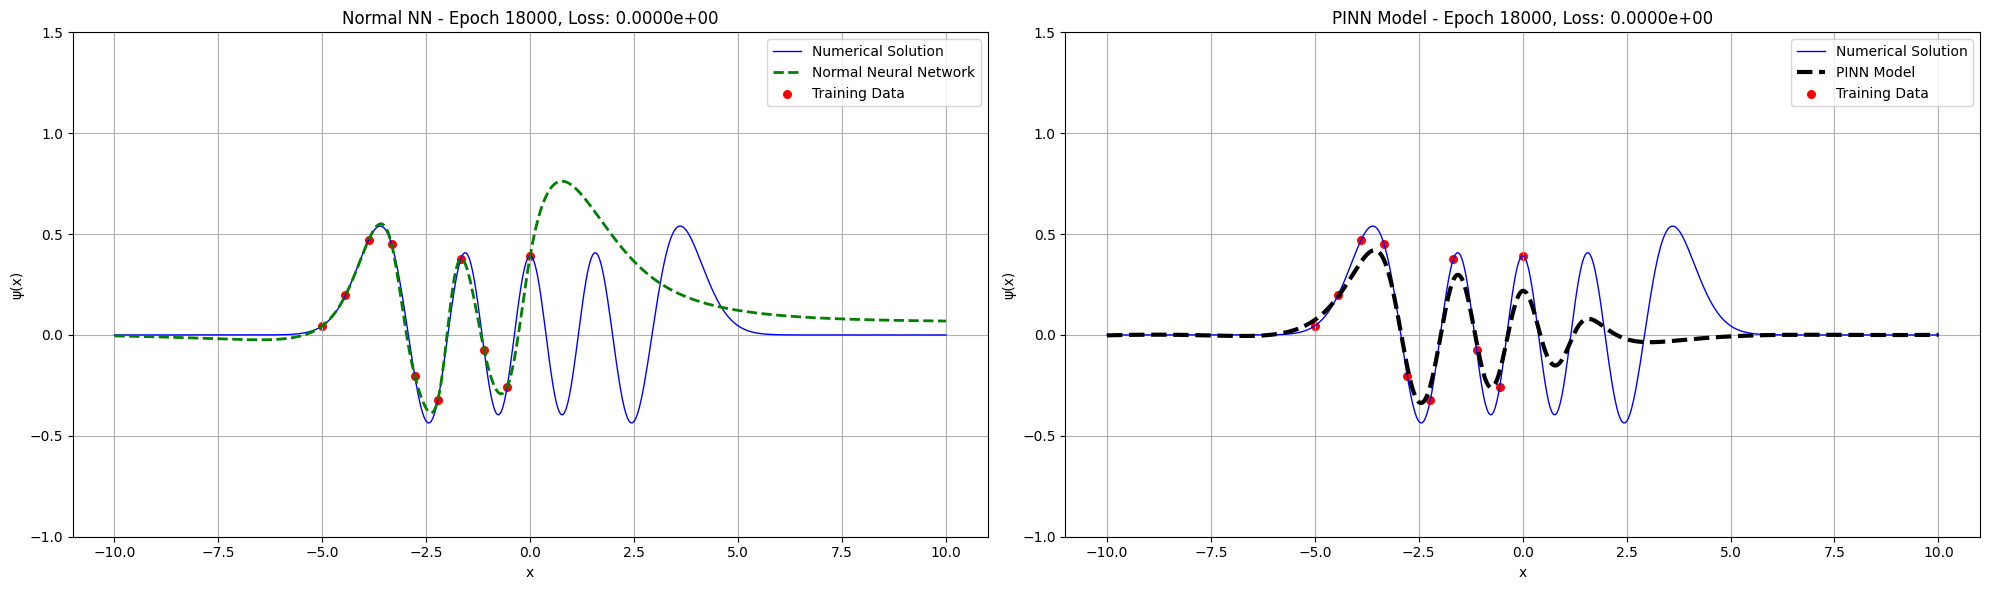

GIF saved successfully.


In [12]:
# Train and compare models for a specific state
print(f"Training and comparing models for state n=2 with sparse data")
train_and_compare(8, n_epochs=18000, num_train_points=10)

In [14]:
from google.colab import files

# Ensure the GIF is in the correct directory
gif_path = 'plots/training_progress.gif'

# Download the GIF
files.download(gif_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Example usage
nn_model = model([32, 32, 32])
print(nn_model)

model(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [21]:
# Example usage
pinn_model = model([32, 32, 32])
print(nn_model)

model(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
"""
# Define the plots directory
plots_dir = 'plots'

# Check if the directory exists
if os.path.exists(plots_dir):
    # Remove all contents in the plots directory
    shutil.rmtree(plots_dir)

# Recreate the empty plots directory
os.makedirs(plots_dir)
"""

"\n# Define the plots directory\nplots_dir = 'plots'\n\n# Check if the directory exists\nif os.path.exists(plots_dir):\n    # Remove all contents in the plots directory\n    shutil.rmtree(plots_dir)\n\n# Recreate the empty plots directory\nos.makedirs(plots_dir)\n"